# 1 Introduction

## Commentaires

### V2: Adaptation de la V1 sur train_V2 (meilleur modèle =best_LGBM)

- impact sur shap_values (LinearExplainer remplacé par Explainer (pb format array des shapvalues avec TreeExplainer))
- en // modification de la fonction def shap_value(cid:int): du repo P7_API_V2

### V1: Sur base train_V1

Cette version semble fonctionner: je réussis à appeler un SK_ID dans l'API qui me renvoie les shap.values

=> modèle splitté en 3: 

    - la partie sampler (qui elle ne sembe pas s'appliquer => j'ai toujours 61498 lignes dans mon df shap values)
    - la partie transformer (transfromer2) = imputer + standard scaler
    - la partie estimateur (LogReg2)

=> A inclure dans P7_2_1 pour vérifier quele shap.base est identique dans l'onglet 'Shap_test' et dans l'onglet 'shap_val

### Remarque: différence entre .loc et .iloc dans le résultat affiché dans l'API

Ave iloc pas d'index affiché / Avec .loc index affiché suivi de : puis donnée souhaitée (impact ajout d'une couche de dictionnaire)

=> Tester le passage du SK_ID dans l'index...

In [52]:
pwd

'c:\\Users\\xavie\\P7\\P7_ML_model'

## 1.1 Imports

In [53]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle
import shap
shap.initjs()

## 1.2 Fonctions utiles

In [54]:
from src.fonctions import result, print_score, decomposition_modele

In [55]:
pd.set_option('display.max_columns', None)

In [56]:
DISPLAY=True

"""If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.
Else they will

This short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"""

"If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.\nElse they will\n\nThis short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"

# 2 Data

## 2.1 Import and display

In [57]:
train_V2=pd.read_csv('../train_V2.csv')

In [58]:
train_V2.shape

(307455, 31)

In [59]:
train_V2=train_V2.sample(frac=0.2)
train_V2.shape

(61491, 31)

# 3 Best model: best_lgbm

In [60]:
pkl_1= open("best_lgbm2.pkl","rb")
best_LGBM=pd.read_pickle(pkl_1)

In [61]:
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [62]:
X=train_V2.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61491, 23)

In [63]:
y=train_V2['TARGET']
y.shape

(61491,)

# 4 Adaptation modèle pour appel SHAP dans l'API

Rappel: Shap ne prend que l'estimateur (et pas le pipeline entier) pour calculer explaienr/shap_values

Or en récupérant le best_lgbm, et en le décomposant, dans l'API je dois faire appel à l'Id des crédits/clients. Cet Id n'est pas utilisé dans le best_lgbml.

2 solutions:

- 1/ j'ajoute l'id dans le bet_model, au risque d'avoir des résultats un peu moins bons => partie 4.1
- 2/ Comme pour l'AMNT_GOOD_PRICE (cf notebook ML), je reconstitue le df après l'entrainement => partie 4.2


## 4.1 Ajout de SK_ID_CURR après entrainement de best_model

- X: df sans SK_ID
- X2: df avec SK_ID

Etapes:

=> RandomUnderSampler sur X2
=> imputer sur X2
=> Suppression de SK_ID_CURR
=> transformer
=>fit LGBM

### New dataframe X2 avec SK_ID_CURR

In [64]:
X2=train_V2.drop(['TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X2.shape


(61491, 24)

In [65]:
y2=y
y2.shape

(61491,)

### Train test split sur base X2

In [66]:
X2

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
133575,254952,1,1,225000.0,1515415.5,40104.0,1.0,0.706975,0.516053,0.626304,14.0,1.353090e+07,0.000000,0.0,0.148474,0.178240,0.026464,52,8.0,225000.0,1,1,1,0
226718,362656,0,1,202500.0,1006920.0,40063.5,2.0,NaN,0.728305,0.511892,10.0,7.517823e+05,0.000000,0.0,0.201108,0.197844,0.039788,42,4.0,101250.0,1,0,1,0
193262,324155,0,1,225000.0,521280.0,26779.5,3.0,NaN,0.117247,0.339288,0.0,0.000000e+00,0.400000,0.0,0.431630,0.119020,0.051373,41,7.0,75000.0,1,1,1,1
211489,345128,1,1,247500.0,509400.0,40374.0,4.0,NaN,0.592913,0.636376,9.0,4.912852e+06,0.000000,0.0,0.485866,0.163127,0.079258,41,7.0,61875.0,1,0,1,1
252186,391855,0,1,135000.0,753840.0,22041.0,1.0,NaN,0.600669,0.652897,0.0,0.000000e+00,0.250000,0.0,0.179083,0.163267,0.029238,54,-0.0,135000.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26856,131215,0,1,270000.0,675000.0,41427.0,3.0,NaN,0.666219,0.466864,7.0,1.416105e+06,0.000000,0.0,0.400000,0.153433,0.061373,33,5.0,90000.0,1,0,1,1
137051,258985,1,1,99000.0,71955.0,7879.5,2.0,0.661492,0.242812,0.411849,11.0,1.652085e+06,0.333333,0.0,1.375860,0.079591,0.109506,55,-0.0,49500.0,1,1,0,1
5861,106862,0,1,90000.0,450000.0,17095.5,2.0,NaN,0.680412,0.569149,2.0,1.163655e+05,0.000000,0.0,0.200000,0.189950,0.037990,31,5.0,45000.0,1,1,1,1
61020,170775,1,0,67500.0,720000.0,21051.0,3.0,NaN,0.693878,0.695622,0.0,0.000000e+00,0.000000,0.0,0.093750,0.311867,0.029237,37,11.0,22500.0,1,0,1,1


In [67]:
X_train,X_test,y_train,y_test=train_test_split(X2,y2,test_size=0.2)

In [68]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49192, 24)
Test set: (12299, 24)
Train target: (49192,)
Test target: (12299,)


### Decomposition du best_lgm

In [69]:
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=6, min_data_in_leaf=500,
                                num_leaves=25))])

In [70]:
 #Sampling 
X_train_rus, y_train_rus=best_LGBM[0].fit_resample(X_train,y_train)
X_train_rus.shape

(8004, 24)

In [71]:
# Fill Nan with simple imputer(median)
X_tr=pd.DataFrame(best_LGBM[1].fit_transform(X_train_rus),columns=X_train_rus.columns)
X_tr.shape

(8004, 24)

In [72]:
# Suppression du SK_ID_CURR
X_tmp=X_tr.drop(['SK_ID_CURR'],axis=1)
X_tmp.shape

(8004, 23)

In [73]:
best_LGBM[2]

StandardScaler()

In [74]:
# Scaling
X_tr_transf=pd.DataFrame(best_LGBM[2].fit_transform(X_tmp), columns=X_tmp.columns)
X_tr_transf.shape

(8004, 23)

In [75]:
X_tr_transf.isna().sum()

FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
AMT_INCOME_TOTAL       0
AMT_CREDIT             0
AMT_ANNUITY            0
CNT_FAM_MEMBERS        0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
Prev_contract_nb       0
Prev_AMT_CREDIT        0
Refused_rate           0
default_payment        0
INCOME_CREDIT_PERC     0
ANNUITY_INCOME_PERC    0
PAYMENT_RATE           0
client_age             0
client_prof_exp        0
INCOME_PER_PERSON      0
Cash_loans             0
GENDER_FEMALE          0
active_client          0
relationship           0
dtype: int64

In [76]:
# Entrainement
best_LGBM[-1].fit(X_tr_transf,y_train_rus)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 4002, number of negative: 4002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 8004, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

LGBMClassifier(max_depth=6, min_data_in_leaf=500, num_leaves=25)

Conclusion => décompostion du modèle en 3 étape:

-> Random Under Sampling + Imputer

-> Scaler

-> LGBM())

### Enregistrement pkl

In [81]:
best_LGBM[:-2]

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median'))])

In [65]:
best_LGBM[-2]

StandardScaler()

In [82]:
pickle_out = open("samplerV2.pkl","wb")
pickle.dump(best_LGBM[:-2], pickle_out)
pickle_out.close()

In [83]:
pickle_out = open("transformer2_V2.pkl","wb")
pickle.dump(best_LGBM[-2], pickle_out)
pickle_out.close()

In [35]:
pickle_out = open("est_LGBM.pkl","wb")
pickle.dump(best_LGBM[-1], pickle_out)
pickle_out.close()

# 5 Tests pour l'API:

Ci dessous: pas à pas de la fonction shap_value(cid:int) du repo P7_API_V2

In [77]:
X2

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
133575,254952,1,1,225000.0,1515415.5,40104.0,1.0,0.706975,0.516053,0.626304,14.0,1.353090e+07,0.000000,0.0,0.148474,0.178240,0.026464,52,8.0,225000.0,1,1,1,0
226718,362656,0,1,202500.0,1006920.0,40063.5,2.0,NaN,0.728305,0.511892,10.0,7.517823e+05,0.000000,0.0,0.201108,0.197844,0.039788,42,4.0,101250.0,1,0,1,0
193262,324155,0,1,225000.0,521280.0,26779.5,3.0,NaN,0.117247,0.339288,0.0,0.000000e+00,0.400000,0.0,0.431630,0.119020,0.051373,41,7.0,75000.0,1,1,1,1
211489,345128,1,1,247500.0,509400.0,40374.0,4.0,NaN,0.592913,0.636376,9.0,4.912852e+06,0.000000,0.0,0.485866,0.163127,0.079258,41,7.0,61875.0,1,0,1,1
252186,391855,0,1,135000.0,753840.0,22041.0,1.0,NaN,0.600669,0.652897,0.0,0.000000e+00,0.250000,0.0,0.179083,0.163267,0.029238,54,-0.0,135000.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26856,131215,0,1,270000.0,675000.0,41427.0,3.0,NaN,0.666219,0.466864,7.0,1.416105e+06,0.000000,0.0,0.400000,0.153433,0.061373,33,5.0,90000.0,1,0,1,1
137051,258985,1,1,99000.0,71955.0,7879.5,2.0,0.661492,0.242812,0.411849,11.0,1.652085e+06,0.333333,0.0,1.375860,0.079591,0.109506,55,-0.0,49500.0,1,1,0,1
5861,106862,0,1,90000.0,450000.0,17095.5,2.0,NaN,0.680412,0.569149,2.0,1.163655e+05,0.000000,0.0,0.200000,0.189950,0.037990,31,5.0,45000.0,1,1,1,1
61020,170775,1,0,67500.0,720000.0,21051.0,3.0,NaN,0.693878,0.695622,0.0,0.000000e+00,0.000000,0.0,0.093750,0.311867,0.029237,37,11.0,22500.0,1,0,1,1


In [82]:
#X2=X2.drop(['SK_ID_CURR'],axis=1)
X2.shape

(61491, 24)

In [79]:
transf_data = pd.DataFrame(best_LGBM[:-2].transform(X2),columns = X2.columns) # fit_resample necessite (X,y)
transf_data.shape

(61491, 24)

In [80]:
data_for_shap=transf_data.drop(['SK_ID_CURR'],axis=1)

In [83]:
data_for_shap_tr=pd.DataFrame(best_LGBM[-2].transform(data_for_shap),columns=data_for_shap.columns)

In [47]:
best_LGBM[-1]

LGBMClassifier(max_depth=6, min_data_in_leaf=500, num_leaves=25)

## Création de l'explaner Shap et des Shap_values

In [103]:
explainer=shap.Explainer(best_LGBM[-1],data_for_shap_tr)

In [104]:
type(explainer)

shap.explainers._tree.Tree

In [ ]:
explainer.

In [105]:
shap_values = explainer(data_for_shap_tr,check_additivity=False)

100%|===================| 61186/61491 [02:13<00:00]        

In [108]:
shap_values.coho    cohorts

<bound method Explanation.cohorts of .values =
array([[-0.06869248,  0.01266203,  0.00062244, ..., -0.08005965,
         0.00479273,  0.00217855],
       [ 0.05691854,  0.01733269,  0.01925664, ...,  0.13699263,
         0.00615901,  0.01135889],
       [ 0.14014955,  0.02056626,  0.00679162, ..., -0.03138684,
         0.00989752, -0.0020346 ],
       ...,
       [ 0.05932608,  0.0126095 ,  0.01961151, ..., -0.0997308 ,
         0.00668353, -0.00705162],
       [-0.07809362, -0.04050418, -0.03065206, ...,  0.12315788,
         0.00487972, -0.00392467],
       [ 0.10686286,  0.01842646,  0.01184055, ..., -0.05754831,
         0.00736146, -0.00213493]])

.base_values =
array([-0.42473208, -0.42473208, -0.42473208, ..., -0.42473208,
       -0.42473208, -0.42473208])

.data =
array([[ 1.42864741,  0.66514815,  0.6944203 , ...,  0.7988428 ,
         0.41459465, -1.6136239 ],
       [-0.69996277,  0.66514815,  0.43591341, ..., -1.25181075,
         0.41459465, -1.6136239 ],
       [-0.699962

In [107]:
type(shap_values)

shap._explanation.Explanation

## Importance globale

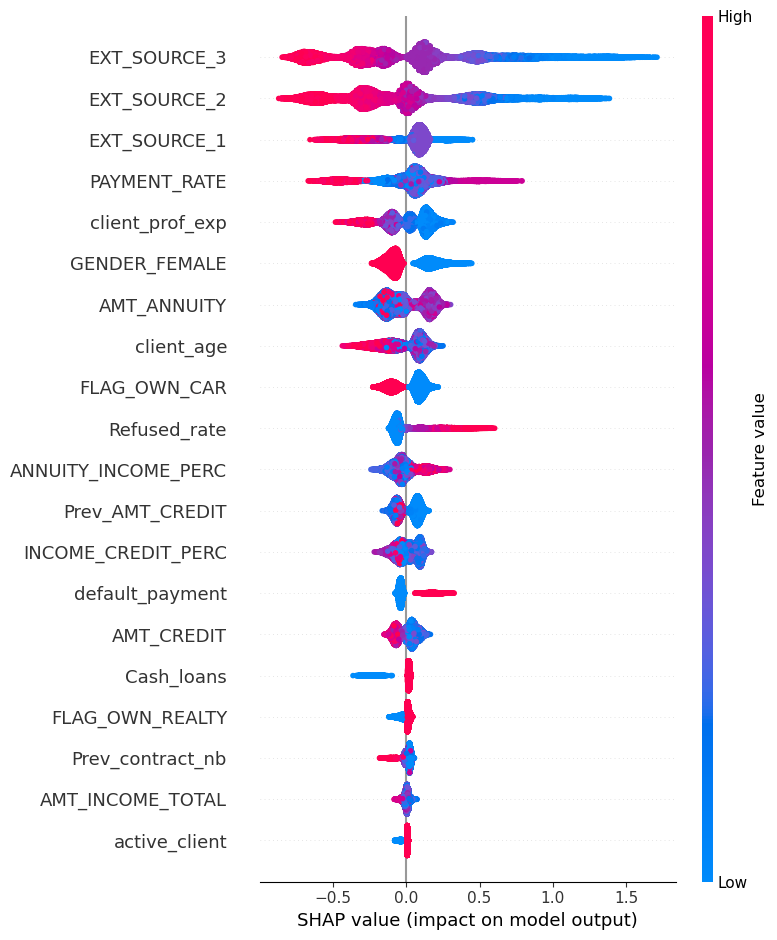

In [96]:
shap.summary_plot(shap_values,data_for_shap)

## Importance locale

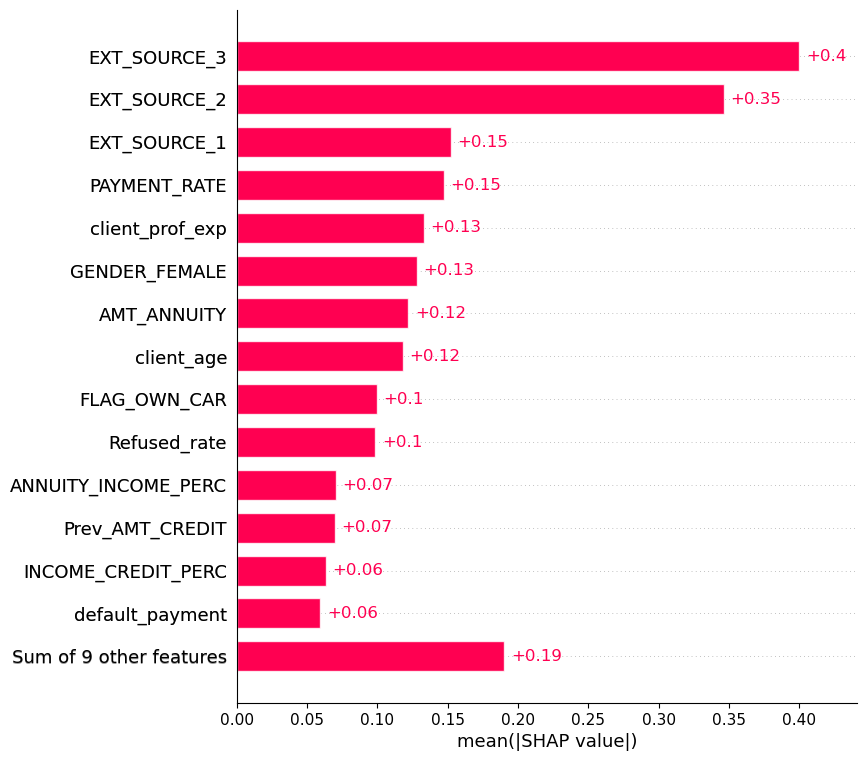

In [97]:
shap.plots.bar(shap_values,max_display=15)

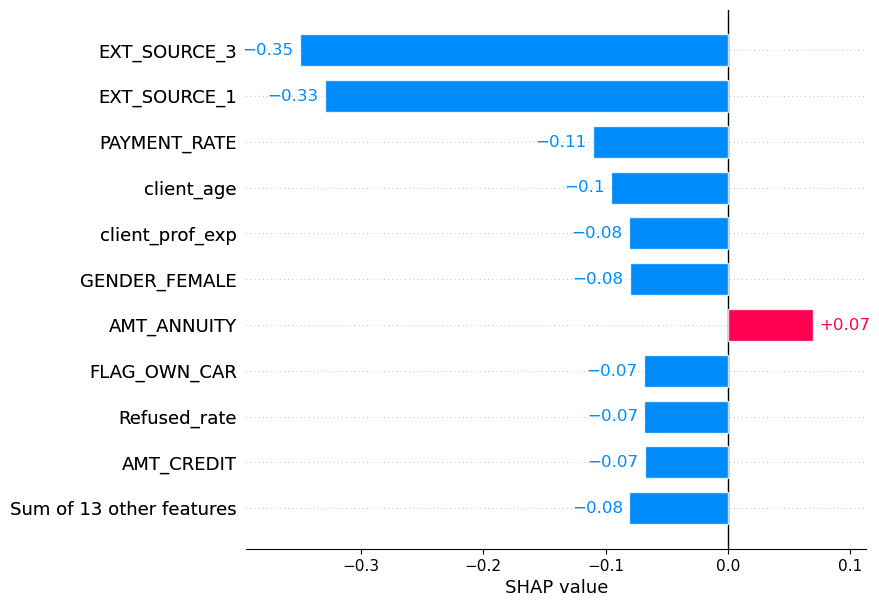

In [98]:
shap.plots.bar(shap_values[0],max_display=11)

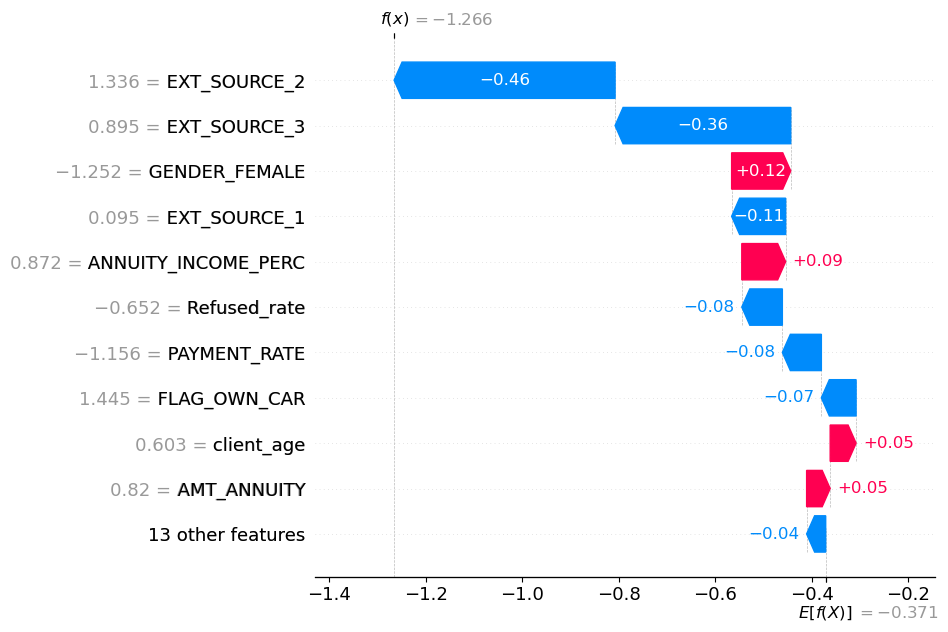

In [144]:
shap.waterfall_plot(shap_values[5], max_display=11)

In [167]:

shap.force_plot(explainer.expected_value,
                explainer.shap_values(data_for_shap.iloc[0]),
                feature_names=data_for_shap.columns)
                #out_names="Conso")

In [168]:
svv=pd.DataFrame(shap_values.values, columns = data_for_shap.columns).round(2)
svv

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
0,0.03,0.0,0.02,0.02,0.03,0.0,0.25,0.90,0.13,0.01,0.05,-0.06,-0.01,-0.01,0.09,0.24,-0.28,0.13,-0.00,0.02,0.18,0.02,0.07
1,0.05,0.0,0.00,0.01,0.02,0.0,0.03,0.56,-0.39,-0.00,-0.02,0.07,-0.01,0.01,0.08,0.09,-0.19,0.08,-0.02,0.02,0.19,-0.10,-0.03
2,0.03,0.0,0.04,0.00,0.00,0.0,0.06,0.77,-0.46,0.03,0.03,0.09,-0.01,-0.02,-0.10,0.07,0.04,-0.06,0.01,-0.15,-0.13,0.02,0.03
3,0.04,0.0,0.02,0.02,-0.01,0.0,0.09,-0.51,1.02,0.01,0.01,-0.08,-0.01,-0.02,-0.09,0.13,0.07,-0.03,0.01,0.02,-0.05,0.01,-0.02
4,0.05,0.0,0.02,0.01,0.01,0.0,-0.80,0.58,0.05,0.01,0.02,0.19,-0.01,-0.03,-0.08,0.13,0.09,0.10,0.01,0.02,0.16,0.02,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61486,0.04,0.0,0.01,0.01,-0.00,0.0,-0.26,-0.38,0.06,-0.02,0.00,0.16,0.04,-0.03,-0.05,0.08,0.08,0.11,-0.04,0.02,-0.07,0.01,-0.01
61487,-0.04,0.0,0.01,0.01,0.02,0.0,0.04,0.19,-0.81,0.01,0.01,0.35,-0.01,-0.03,-0.05,0.14,-0.19,0.07,0.01,0.02,-0.12,-0.11,-0.02
61488,0.05,0.0,-0.00,0.01,-0.02,0.0,0.03,-0.46,-0.43,0.01,0.01,-0.08,-0.01,0.03,0.06,-0.05,-0.15,-0.00,-0.02,0.01,-0.08,0.02,-0.03
61489,-0.04,0.0,0.01,-0.04,0.04,0.0,0.06,0.15,-0.43,0.01,0.03,-0.06,-0.01,-0.01,-0.02,-0.18,-0.10,0.09,0.00,0.02,0.18,0.02,0.08


In [169]:
svv['SK_ID_CURR']=transf_data['SK_ID_CURR']
svv

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,SK_ID_CURR
0,0.03,0.0,0.02,0.02,0.03,0.0,0.25,0.90,0.13,0.01,0.05,-0.06,-0.01,-0.01,0.09,0.24,-0.28,0.13,-0.00,0.02,0.18,0.02,0.07,312492.0
1,0.05,0.0,0.00,0.01,0.02,0.0,0.03,0.56,-0.39,-0.00,-0.02,0.07,-0.01,0.01,0.08,0.09,-0.19,0.08,-0.02,0.02,0.19,-0.10,-0.03,342441.0
2,0.03,0.0,0.04,0.00,0.00,0.0,0.06,0.77,-0.46,0.03,0.03,0.09,-0.01,-0.02,-0.10,0.07,0.04,-0.06,0.01,-0.15,-0.13,0.02,0.03,394167.0
3,0.04,0.0,0.02,0.02,-0.01,0.0,0.09,-0.51,1.02,0.01,0.01,-0.08,-0.01,-0.02,-0.09,0.13,0.07,-0.03,0.01,0.02,-0.05,0.01,-0.02,295113.0
4,0.05,0.0,0.02,0.01,0.01,0.0,-0.80,0.58,0.05,0.01,0.02,0.19,-0.01,-0.03,-0.08,0.13,0.09,0.10,0.01,0.02,0.16,0.02,-0.03,243273.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61486,0.04,0.0,0.01,0.01,-0.00,0.0,-0.26,-0.38,0.06,-0.02,0.00,0.16,0.04,-0.03,-0.05,0.08,0.08,0.11,-0.04,0.02,-0.07,0.01,-0.01,404498.0
61487,-0.04,0.0,0.01,0.01,0.02,0.0,0.04,0.19,-0.81,0.01,0.01,0.35,-0.01,-0.03,-0.05,0.14,-0.19,0.07,0.01,0.02,-0.12,-0.11,-0.02,290187.0
61488,0.05,0.0,-0.00,0.01,-0.02,0.0,0.03,-0.46,-0.43,0.01,0.01,-0.08,-0.01,0.03,0.06,-0.05,-0.15,-0.00,-0.02,0.01,-0.08,0.02,-0.03,107441.0
61489,-0.04,0.0,0.01,-0.04,0.04,0.0,0.06,0.15,-0.43,0.01,0.03,-0.06,-0.01,-0.01,-0.02,-0.18,-0.10,0.09,0.00,0.02,0.18,0.02,0.08,363140.0
